# A2.2
# Mai Zeng
# 260782174

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import segmentation, color
from skimage.future import graph
from skimage.segmentation import quickshift
import os
import math
from PIL import Image

## 2 Matching using SIFT - Book Reveal

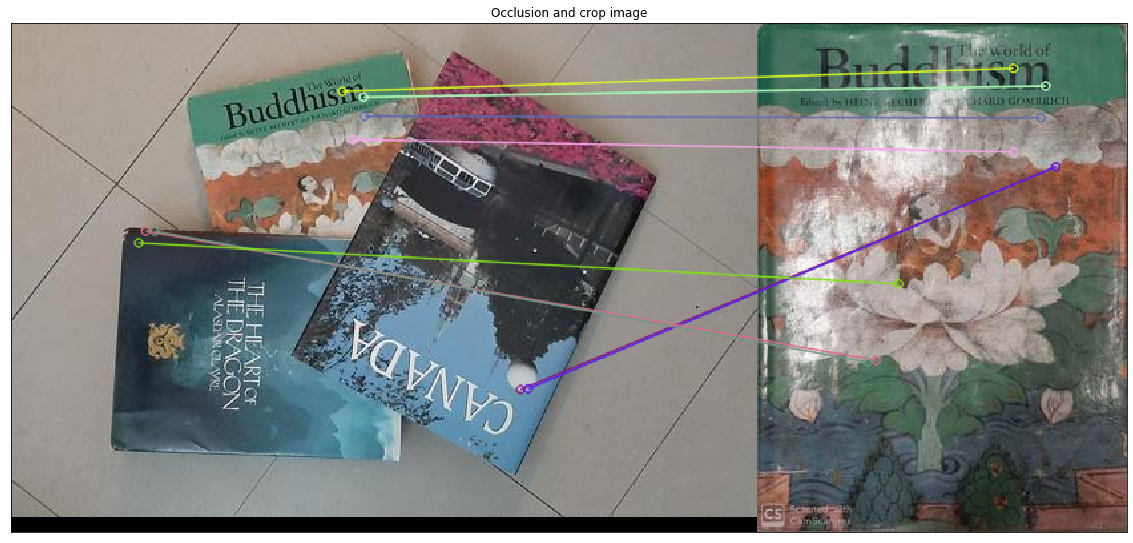

In [2]:
# Find SIFT keypoints in given input images.
# load image 
img = cv2.imread("book_occlusion.jpg")
img_occlusion = cv2.imread("book_occlusion.jpg")
img_crop = cv2.imread("book_crop.jpg")
# copy image
img_occlusion_copy = img_occlusion.copy()
img_crop_copy = img_crop.copy()
# convert to RGB
img_occlusion = cv2.cvtColor(img_occlusion, cv2.COLOR_BGR2RGB)
img_occlusion_copy = cv2.cvtColor(img_occlusion_copy, cv2.COLOR_BGR2RGB)
img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
img_crop_copy = cv2.cvtColor(img_crop_copy, cv2.COLOR_BGR2RGB)

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features
title = "Occlusion and crop image"

# Match keypoints of reference image to the keypoints of the occluded image using brute-force method.
# detect SIFT features, with no masks
# 'None' is a mask but here is no masks so it is none
# Sometime we want to just compute the key points just in the mask
keypoints_occlusion,descriptors_occlusion = sift.detectAndCompute(img_occlusion_copy,None)
keypoints_crop,descriptors_crop = sift.detectAndCompute(img_crop_copy,None)

# create BFMatcher object
# BF == brute force
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)\

# Match keypoints of reference image to the keypoints of the occluded image using brute-force method.
# Match descriptors.
# Match the first arguement to the second
matches = bf.match(descriptors_occlusion,descriptors_crop) #query image, train image

# Sort matching keypoints according to the matching distance.
matches = sorted(matches, key = lambda x:x.distance)

# Display top ten matching keypoints.
img_matches = cv2.drawMatches(img_occlusion_copy,keypoints_occlusion
                              ,img_crop_copy,keypoints_crop, matches[:10], None, flags=2)
plt.figure(figsize=(20,20))
plt.imshow(img_matches)
plt.title(title), plt.xticks([]), plt.yticks([])
plt.show()

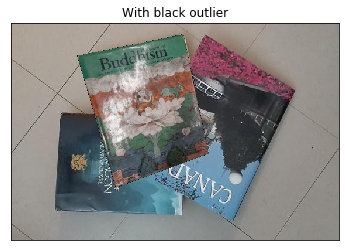

In [3]:
# Compute a homography to align the images using RANSAC method and apply the transformation on the reference image.
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 200:
        GoodMatches.append((m.queryIdx, m.trainIdx))
mp_occlusion = np.float32([keypoints_occlusion[i].pt for (i, __) in GoodMatches])
mp_crop = np.float32([keypoints_crop[i].pt for (__, i) in GoodMatches])

H, __ = cv2.findHomography(mp_crop, mp_occlusion, cv2.RANSAC, 1)

wimg = cv2.warpPerspective(img_crop_copy, H, (img_occlusion_copy.shape[1]+img_crop_copy.shape[1]
                                                   ,img_crop_copy.shape[0]))

# Paste transformed reference image on the occluded view to generate unoccluded view
B = wimg
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
            if np.all(B[i, j] != 0):
                img_occlusion[i,j] = wimg[i,j]
      
plt.imshow(img_occlusion)
plt.title("With black outlier"), plt.xticks([]), plt.yticks([])
plt.show()

# plt.imshow(B)
# plt.title("B"), plt.xticks([]), plt.yticks([])
# plt.show()
# img_occlusion = cv2.medianBlur(img_occlusion, 19)
                
# plt.imshow(img_occlusion)
# plt.title("With black outlier"), plt.xticks([]), plt.yticks([])
# plt.show()

